
# Обработка данных студентов из БАРС

## Загрузка модулей и данных


In [2]:
import re
import logging
import time
from time import time

import numpy as np
import pandas as pd
#import nltk

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from pylab import rcParams
import seaborn as sns

from collections import Counter

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import LinearSVC

import pickle as pickle

from collections import OrderedDict

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

random_state = 42 
pd.set_option('display.max_columns', None)

In [3]:
# Загружаем выборку и перобразуем в удобный DataFrame
data_student = pd.read_csv('C:\\Institute\\students\student.csv', '|', encoding='utf-16')
df_student = pd.DataFrame(data_student)

data_student_event = pd.read_csv('C:\\Institute\\students\student_event.csv', '|', encoding='utf-16')
df_student_event = pd.DataFrame(data_student_event)

data_mark = pd.read_csv('C:\\Institute\\students\mark.csv', '|', encoding='utf-16')
df_mark = pd.DataFrame(data_mark)

### Количество пропущенных данных по столбцам

In [4]:
print(df_student.isna().sum())

№                                                              0
Личность. ИД                                                   0
Личность. Фамилия                                             19
Личность. Имя                                                  2
Личность. Отчество                                          1778
Личность. Пол                                                  0
Личность. Дата рождения                                       10
Личность. Гражданство                                          2
Личность. Местро рождения. Регион                          32335
Личность. Местро рождения. Страна                          49670
Личность. Место жительства. Регион                          4322
Личность. Место жительства. Страна                          3868
Личность. Место жительства. Постоянная прописка. Регион     4731
Личность. Место жительства. Постоянная прописка. Страна     3436
Студент. ИД                                                    0
Студент. Номер зачётной к

In [5]:
# Пока ничего не удаляем
#del df_student['Личность. Местро рождения. Регион']
#del df_student['Личность. Местро рождения. Страна']
##del df_student['Личность. Место жительства. Регион']
#del df_student['Личность. Место жительства. Страна']
##del df_student['Личность. Место жительства. Постоянная прописка. Регион']
#del df_student['Личность. Место жительства. Постоянная прописка. Страна']
#del df_student['Студент. Текущее обучение. Причина отчисления']
#del df_student['Студент. Текущее обучение. Причина попадания в статус']


In [38]:
df_student

,№,Личность. ИД,Личность. Фамилия,Личность. Имя,Личность. Отчество,Личность. Пол,Личность. Дата рождения,Личность. Гражданство,Личность. Местро рождения. Регион,Личность. Местро рождения. Страна,Личность. Место жительства. Регион,Личность. Место жительства. Страна,Личность. Место жительства. Постоянная прописка. Регион,Личность. Место жительства. Постоянная прописка. Страна,Студент. ИД,Студент. Номер зачётной книжки,Студент. Дата поступления,Студент. Год поступления,Студент. Дата окончания (ожидаемая),Студент. Дата отчисления,Студент. Тип гражданства,Студент. Категория поступления,Студент. Сумма баллов ЕГЭ,Студент. Текущее обучение. Учебная группа. Курс,Студент. Текущее обучение. Семестр обучения,Студент. Текущее обучение. Учебная группа,Студент. Текущее обучение. Институт,Студент. Текущее обучение. Кафедра,Студент. Текущее обучение. Статус обучения,Студент. Текущее обучение. Форма обучения,Студент. Текущее обучение. Квалификация,Студент. Текущее обучение. Направление,Студент. Текущее обучение. Причина отчисления,Студент. Текущее обучение. Причина попадания в статус,Студент. Первое обучение. Учебная группа,Студент. Первое обучение. Институт,Студент. Первое обучение. Кафедра,Студент. Первое обучение. Статус обучения,Студент. Первое обучение. Форма обучения,Студент. Первое обучение. Квалификация,Студент. Первое обучение. Направление,Студент. Категория поступления укрупненно,type_string,type
0,1,{9E02B810-0318-EC11-80D6-005056BEEEDD},NaN,Аунг Пьё,NaN,Мужской,28.05.1995,Мьянма,NaN,NaN,Город Москва,NaN,NaN,Мьянма,{3667532E-0318-EC11-80D6-005056BEEEDD},0020218106,01.09.2021,2021,31.08.2023,NaN,Иностранец,По конкурсу,70.0,1.0,1.0,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
1,2,{C9C33E91-1FFD-EA11-80D4-005056BEEEDD},NaN,Аунг Че Мин,NaN,Мужской,02.05.1994,Мьянма,МЬЯНМА,NaN,Москва г,Россия,NaN,NaN,{A543EDB6-1FFD-EA11-80D4-005056BEEEDD},0020209686,01.09.2020,2020,31.08.2023,NaN,Иностранец,По конкурсу,64.0,1.0,1.0,А-13м-21,ИВТИ,ПМИИ,Обучается,Очная,Магистр,01.04.02 Прикладная математика и информатика,NaN,NaN,А-13м-21,ИВТИ,ПМИИ,Обучается,Очная,Магистр,01.04.02 Прикладная математика и информатика,По конкурсу,Очная_По конкурсу_Магистр,2
2,3,{09D38C2D-F126-EC11-80D6-005056BEEEDD},NaN,До Хай Киен,NaN,Мужской,17.02.2002,Вьетнам,NaN,NaN,NaN,Вьетнам,NaN,Вьетнам,{535DA04A-F126-EC11-80D6-005056BEEEDD},0020218788,01.09.2021,2021,31.08.2025,NaN,Иностранец,По конкурсу,100.0,1.0,1.0,Ав-12-21,ИВТИ,ВМСС,Академический отпуск,Очная,Бакалавр,09.03.01 Информатика и вычислительная техника,NaN,NaN,Ав-12-21,ИВТИ,ВМСС,Обучается,Очная,Бакалавр,09.03.01 Информатика и вычислительная техника,По конкурсу,Очная_По конкурсу_Бакалавр,1
3,4,{A802B810-0318-EC11-80D6-005056BEEEDD},NaN,Зин Вин Хту,NaN,Мужской,10.06.1996,Мьянма,NaN,NaN,Город Москва,NaN,NaN,Мьянма,{3C67532E-0318-EC11-80D6-005056BEEEDD},0020218108,01.09.2021,2021,31.08.2023,NaN,Иностранец,По конкурсу,80.0,1.0,1.0,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
4,5,{CEC33E91-1FFD-EA11-80D4-005056BEEEDD},NaN,Зин Ко,NaN,Мужской,04.07.1994,Мьянма,Республика Союз Мьянма,NaN,Москва г,Россия,NaN,NaN,{A843EDB6-1FFD-EA11-80D4-005056BEEEDD},0020209687,01.09.2020,2020,31.08.2022,NaN,Иностранец,По конкурсу,66.0,2.0,3.0,ИГ-02м-20,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-20,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49668,87018,{03297E42-831D-EC11-80D6-005056BEEEDD},Я

## Распределение по полу

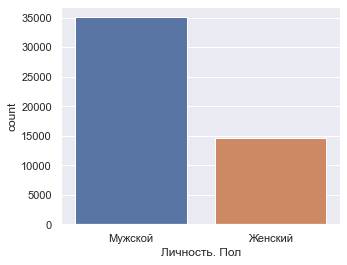

In [7]:
sns.set(rc={'figure.figsize':(5,4)})
sns.countplot(x=df_student['Личность. Пол'].fillna('unknown'))

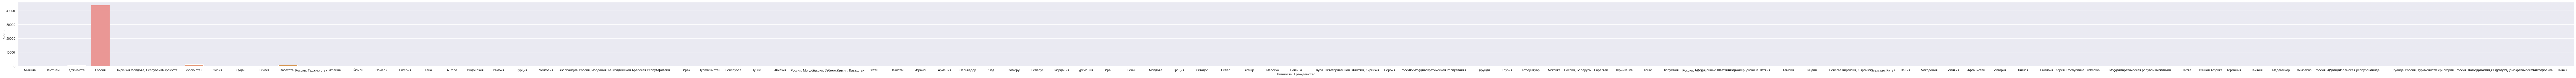

In [51]:
sns.set(rc={'figure.figsize':(155,4)})
sns.countplot(x=df_student['Личность. Гражданство'].fillna('unknown'))

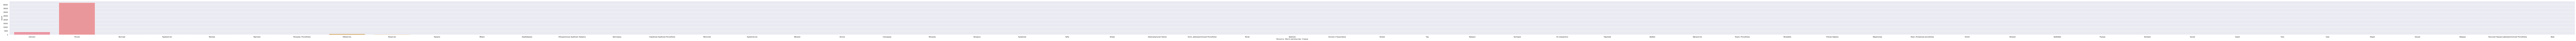

In [44]:
sns.set(rc={'figure.figsize':(300,4)})
sns.countplot(x=df_student['Личность. Место жительства. Страна'].fillna('unknown'))

## Категория поступления
Пропусков данных нет. 
Делаем укрупненные категории - По конкурсу, Платное, прочее

In [8]:
df_student['Студент. Категория поступления'].unique()

array(['По конкурсу', 'Платное обучение',
       'Без вступительных испытаний - направления Минобрнауки РФ',
       'Без экзаменов', 'Целевое обучение',
       'Дети-сироты и дети, оставшиеся без попечения родителей по квоте',
       'Чернобыльцы', 'Конкурс с преимуществом',
       'Инвалиды с детства по квоте', 'Дети-сироты', 'Не задано',
       'Платное по собеседованию',
       'Дети военнослужащих, погибших при исполнении. Конкурс с преимуществом',
       'Дети-инвалиды по квоте', 'Инвалиды I и II групп',
       'Инвалиды I и II групп по квоте',
       'Дети инвалиды  I и II группы по конкурсу с преимуществом',
       'По квоте - ветераны боевых действий',
       'Дети умерших (погибших) сотрудников органов внутренних дел и учреждений. Конкурс с преимуществом',
       'Военнослужащие проходящие службу по контракту. Конкурс с преимуществом',
       'Конкурс с преимуществом - инвалиды вследствие военной травмы или заболевания в период военной службы',
       'Дети-сироты, оставшиеся 

In [9]:
df_student['Студент. Категория поступления укрупненно'] = 'Прочее'
df_student['Студент. Категория поступления укрупненно'].loc[df_student['Студент. Категория поступления'] == 'По конкурсу'] = 'По конкурсу'
df_student['Студент. Категория поступления укрупненно'].loc[df_student['Студент. Категория поступления'] == 'Платное обучение'] = 'Платное обучение'

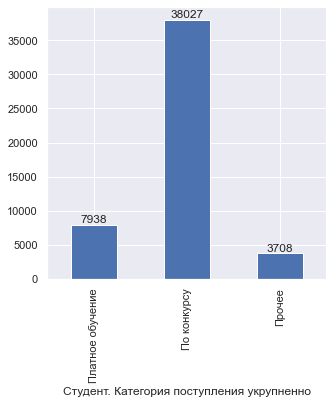

In [10]:
ax = df_student.groupby(['Студент. Категория поступления укрупненно'])['Личность. ИД'].count().plot.bar(figsize=(5,5))
rects = ax.patches

# Make some labels.
labels = df_student.groupby(['Студент. Категория поступления укрупненно'])['Личность. ИД'].count()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

# Квалификация
Пропущено 37 строк - удаляем


In [11]:
#df_student
#49673 

df_student.dropna(subset=['Студент. Текущее обучение. Квалификация'], inplace=True)
#49636 

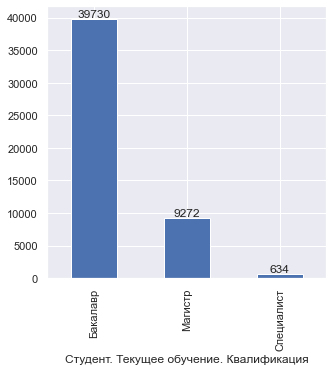

In [12]:
ax = df_student.groupby(['Студент. Текущее обучение. Квалификация'])['Личность. ИД'].count().plot.bar(figsize=(5,5))
rects = ax.patches

# Make some labels.
labels = df_student.groupby(['Студент. Текущее обучение. Квалификация'])['Личность. ИД'].count()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")

plt.show()

In [13]:
df_student.loc[df_student['Студент. Текущее обучение. Квалификация'] == 'Специалист']

,№,Личность. ИД,Личность. Фамилия,Личность. Имя,Личность. Отчество,Личность. Пол,Личность. Дата рождения,Личность. Гражданство,Личность. Местро рождения. Регион,Личность. Местро рождения. Страна,Личность. Место жительства. Регион,Личность. Место жительства. Страна,Личность. Место жительства. Постоянная прописка. Регион,Личность. Место жительства. Постоянная прописка. Страна,Студент. ИД,Студент. Номер зачётной книжки,Студент. Дата поступления,Студент. Год поступления,Студент. Дата окончания (ожидаемая),Студент. Дата отчисления,Студент. Тип гражданства,Студент. Категория поступления,Студент. Сумма баллов ЕГЭ,Студент. Текущее обучение. Учебная группа. Курс,Студент. Текущее обучение. Семестр обучения,Студент. Текущее обучение. Учебная группа,Студент. Текущее обучение. Институт,Студент. Текущее обучение. Кафедра,Студент. Текущее обучение. Статус обучения,Студент. Текущее обучение. Форма обучения,Студент. Текущее обучение. Квалификация,Студент. Текущее обучение. Направление,Студент. Текущее обучение. Причина отчисления,Студент. Текущее обучение. Причина попадания в статус,Студент. Первое обучение. Учебная группа,Студент. Первое обучение. Институт,Студент. Первое обучение. Кафедра,Студент. Первое обучение. Статус обучения,Студент. Первое обучение. Форма обучения,Студент. Первое обучение. Квалификация,Студент. Первое обучение. Направление,Студент. Категория поступления укрупненно
188,241,{8D271A01-837E-E611-80C0-005056BEEEDD},Абдуллазянов,Равильджан,Рахимзянович,Мужской,16.07.1993,Россия,NaN,NaN,Татарстан респ,Россия,Татарстан респ,Россия,{1860A162-997E-E611-80C0-005056BEEEDD},0020104031,01.12.2015,2015,03.03.2016,03.03.2016,Гражданин РФ,По конкурсу,NaN,12.0,NaN,ИЭ-121к-10,ИнЭИ,NaN,Завершил обучение,Очно-заочная (вечерняя),Специалист,080502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу
364,498,{4CD01407-837E-E611-80C0-005056BEEEDD},Абрамова,Яна,Александровна,Женский,15.01.1993,Россия,NaN,NaN,Татарстан респ,Россия,Татарстан респ,Россия,{50A59968-997E-E611-80C0-005056BEEEDD},0020104032,01.12.2015,2015,04.03.2016,04.03.2016,Гражданин РФ,По конкурсу,NaN,12.0,NaN,ИЭ-122к-10,ИнЭИ,NaN,Завершил обучение,Очно-заочная (вечерняя),Специалист,080502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу
402,569,{21E0C7AC-71B5-E911-80CF-005056BEEEDD},Авакян,Хорен,Мартунович,Мужской,18.11.2000,Россия,МОСКОВСКАЯ ОБЛ.,NaN,Московская об-ть,Россия,Московская об-ть,Россия,{7F744F15-37B8-E911-80CF-005056BEEEDD},0020194390,01.09.2019,2019,28.02.2025,NaN,Гражданин РФ,По конкурсу,198.0,3.0,5.0,ЭР-22-19,ИРЭ,РТС,Обучается,Очная,Специалист,11.05.01 Радиоэлектронные системы и комплексы,NaN,NaN,ЭР-22-19,ИРЭ,РТС,Обучается,Очная,Специалист,11.05.01 Радиоэлектронные системы и комплексы,По конкурсу
463,659,{4CBAFAD3-B192-E811-80CB-005056BEEEDD},Аверин,Александр,Сергеевич,Мужской,21.12.2000,Россия,БЕЛГОРОДСКАЯ ОБЛ.,NaN,Белгородская об-ть,Россия,Белгородская об-ть,Россия,{552C04F7-B192-E811-80CB-005056BEEEDD},0020180719,01.09.2018,2018,01.03.2024,NaN,Гражданин РФ,Целевое обучение,184.0,4.0,7.0,ЭР-21-18,ИРЭ,РТС,Обучается,Очная,Специалист,11.05.01 Радиоэлектронные системы и комплексы,NaN,NaN,ЭР-21-18,ИРЭ,РТС,Обучается,Очная,Специалист,11.05.01 Радиоэлектронные системы и комплексы,Прочее
473,674,{76D11407-837E-E611-80C0-005056BEEEDD},Аверичева,Александра,Сергеевна,Женский,07.09.1994,Россия,NaN,NaN,Московская обл,Россия,Московская обл,Россия,{361A7A9D-987E-E611-80C0-005056BEEEDD},0020121407,01.09.2012,2012,25.06.2014,25.06.2014,Гражданин РФ,По конкурсу,NaN,10.0,4.0,ЭР-14-12,ИРЭ,NaN,Отчислен,Очная,Специалист,11.05.01 (ФГОС) Радиоэлектронные системы и ком...,отчислен в ИРИСе,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49352,86504,{4CB0D83F-8C7E-E611-80C0-005056BEEEDD},Якубова,Гузель,Фаилевна,Женский,27.10.1992,Россия,NaN,NaN,Татарстан респ,Россия,Татарстан респ,Россия,{6DA59968-997E-E611-80C0-005056BEEEDD},2010

## Форма обучения
Пустые уже удалили

In [14]:
df_student['Студент. Текущее обучение. Форма обучения'].unique()

array(['Очная', 'Очно-заочная (вечерняя)', 'Заочная'], dtype=object)

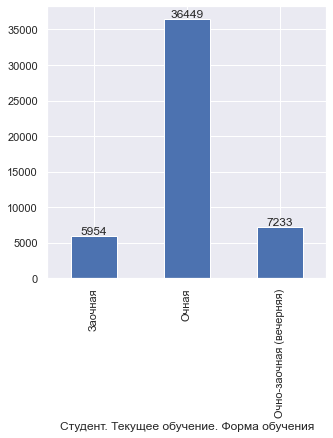

In [15]:
ax = df_student.groupby(['Студент. Текущее обучение. Форма обучения'])['Личность. ИД'].count().plot.bar(figsize=(5,5))
rects = ax.patches

# Make some labels.
labels = df_student.groupby(['Студент. Текущее обучение. Форма обучения'])['Личность. ИД'].count()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

# Назначем категории студентам

Форма | Тип | Квалификация | Код
--- | --- | --- | --- 
Очное | по конкурсу | бакалавр | 1
Очное | по конкурсу | магистр | 2
Очное | платное | бакалавр | 3
Очное | платное | магистр | 4 
Очное | прочее | бакалавр | 5
Очное | прочее | магистр | 6
Заочное | по конкурсу | бакалавр | 7
Заочное | по конкурсу | магистр | 8
Заочное | платное | бакалавр | 9
Заочное | платное | магистр | 10
Заочное | прочее | бакалавр | 11
Заочное | прочее | магистр | 12
Вечернее | по конкурсу | бакалавр | 13
Вечернее | по конкурсу | магистр | 14
Вечернее | платное | бакалавр | 15
Вечернее | платное | магистр | 16
Вечернее | прочее | бакалавр | 17
Вечернее | прочее | магистр | 18

In [16]:
df_student['type_string'] = df_student['Студент. Текущее обучение. Форма обучения'] + "_" + df_student['Студент. Категория поступления укрупненно'] + "_" + df_student['Студент. Текущее обучение. Квалификация'] 
df_student['type_string'].unique()
df_student['type'] = 0
df_student['type'].loc[df_student['type_string'] == 'Очная_По конкурсу_Бакалавр'] = 1
df_student['type'].loc[df_student['type_string'] == 'Очная_По конкурсу_Магистр'] = 2
df_student['type'].loc[df_student['type_string'] == 'Очная_Платное обучение_Бакалавр'] = 3
df_student['type'].loc[df_student['type_string'] == 'Очная_Платное обучение_Магистр'] = 4
df_student['type'].loc[df_student['type_string'] == 'Очная_Прочее_Бакалавр'] = 5
df_student['type'].loc[df_student['type_string'] == 'Очная_Прочее_Магистр'] = 6
df_student['type'].loc[df_student['type_string'] == 'Заочная_По конкурсу_Бакалавр'] = 7
df_student['type'].loc[df_student['type_string'] == 'Заочная_По конкурсу_Магистр'] = 8
df_student['type'].loc[df_student['type_string'] == 'Заочная_Платное обучение_Бакалавр'] = 9
df_student['type'].loc[df_student['type_string'] == 'Заочная_Платное обучение_Магистр'] = 10
df_student['type'].loc[df_student['type_string'] == 'Заочная_Прочее_Бакалавр'] = 11
df_student['type'].loc[df_student['type_string'] == 'Заочная_Прочее_Магистр'] = 12
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_По конкурсу_Бакалавр'] = 13
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_По конкурсу_Магистр'] = 14
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Платное обучение_Бакалавр'] = 15
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Платное обучение_Магистр'] = 16
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Прочее_Бакалавр'] = 17
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Прочее_Магистр'] = 18
df_student['type'].loc[df_student['type_string'] == 'Очная_По конкурсу_Специалист'] = 19
df_student['type'].loc[df_student['type_string'] == 'Очная_Платное обучение_Специалист'] = 20
df_student['type'].loc[df_student['type_string'] == 'Очная_Прочее_Специалист'] = 21
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_По конкурсу_Специалист'] = 22
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Платное обучение_Специалист'] = 23
df_student['type'].loc[df_student['type_string'] == 'Очно-заочная (вечерняя)_Прочее_Специалист'] = 24
df_student['type'].loc[df_student['type_string'] == 'Заочная_По конкурсу_Специалист'] = 25
df_student['type'].loc[df_student['type_string'] == 'Заочная_Платное обучение_Специалист'] = 26
df_student['type'].loc[df_student['type_string'] == 'Заочная_Прочее_Специалист'] = 27

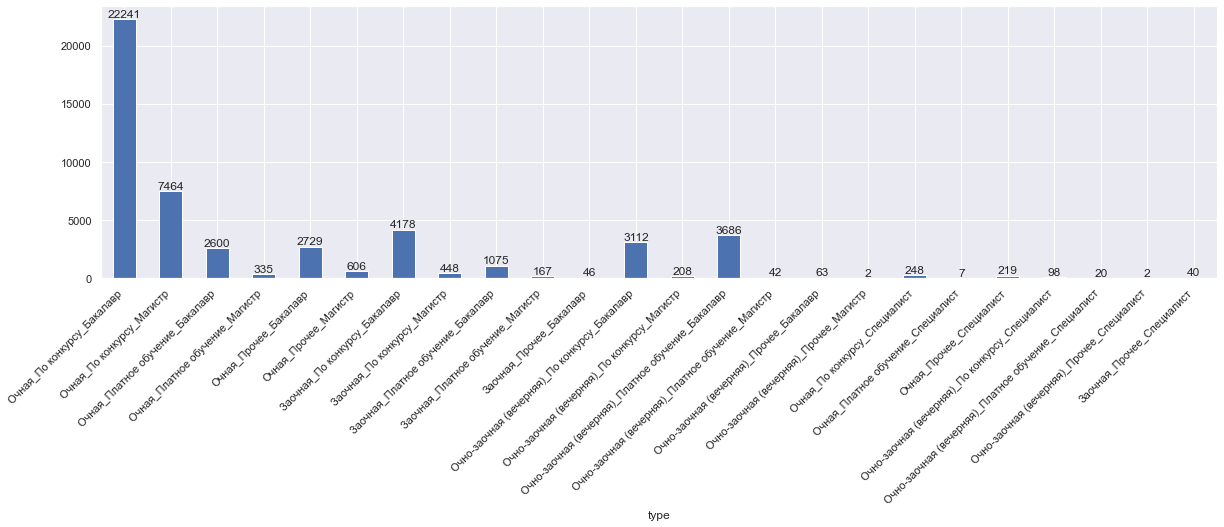

In [17]:
plt.figure(figsize=(20,5))
ax = df_student.groupby('type')['Личность. ИД'].count().plot.bar()
#plt.xticks(rotation=45)

rects = ax.patches
labels = df_student.groupby(['type'])['Личность. ИД'].count()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    ax.set_xticklabels(df_student.sort_values(['type']).groupby(['type'])['type_string'].max(), rotation = 45, ha = 'right')
    
plt.show()

#### Список интересных для нас групп


In [18]:
#Список интересных для нас и достаточных по объему (>300) типов студентов
valid_types_list = [1,2,3,4,5,6,7,8,9,13,15]

df_valid_types = pd.DataFrame() 
#df_valid_types['type'] = valid_types_list
#for i in valid_types_list:
#    df_valid_types.loc[df_valid_types['type'] == i] = df_student.loc[df_student['type'] == i]['type_string'].min()
df_valid_types['type'] = df_student.loc[df_student['type'].isin(valid_types_list)].groupby('type')['type'].first()
df_valid_types['type_string'] = df_student.loc[df_student['type'].isin(valid_types_list)].groupby('type')['type_string'].first()

In [19]:
df_valid_types

,type,type_string
type,,
1,1,Очная_По конкурсу_Бакалавр
2,2,Очная_По конкурсу_Магистр
3,3,Очная_Платное обучение_Бакалавр
4,4,Очная_Платное обучение_Магистр
5,5,Очная_Прочее_Бакалавр
6,6,Очная_Прочее_Магистр
7,7,Заочная_По конкурсу_Бакалавр
8,8,Заочная_По конкурсу_Магистр
9,9,Заочная_Платное обучение_Бакалавр


# Институты

In [20]:
df_student['Студент. Текущее обучение. Институт'].unique()
#df_student.loc[df_student['Студент. Первое обучение. Институт'] == 'ЦП ИЛ']

array(['ИГВИЭ', 'ИВТИ', 'ИЭТЭ', 'ИМЭЭП', 'ИЭЭ', 'ИДДО', 'ИнЭИ', 'ИЭТ',
       'АВТИ', 'ИТАЭ', 'ИЭВТ', 'ГПИ', 'ЭнМИ', 'ЦП ИИЭБ', 'ИРЭ', 'ИТЭП Э',
       'ИПЭЭФ', 'ДМ', nan, 'Кафедра ЭКО', 'ЭУ', 'ЦП Фесто', 'ИТЭП М',
       'ЦП ИЛ'], dtype=object)

In [21]:

df_student = df_student.loc[~df_student['Студент. Текущее обучение. Институт'] \
                            .isin(["ЦП ИЛ","ИТЭП М","ЦП Фесто","ЦП ИИЭБ",'ИТЭП Э','Кафедра ЭКО', 'ЭУ', 'ДМ'])]


df_student.loc[(df_student['Студент. Первое обучение. Институт'] == "АВТИ"), 'Студент. Первое обучение. Институт'] = "ИВТИ"
df_student.loc[(df_student['Студент. Первое обучение. Институт'] == "ИЭТ"), 'Студент. Первое обучение. Институт'] = "ИЭТЭ"
df_student.loc[(df_student['Студент. Первое обучение. Институт'] == "ИПЭЭФ"), 'Студент. Первое обучение. Институт'] = "ИЭВТ"

df_student.loc[(df_student['Студент. Текущее обучение. Институт'] == "АВТИ"), 'Студент. Текущее обучение. Институт'] = "ИВТИ"
df_student.loc[(df_student['Студент. Текущее обучение. Институт'] == "ИЭТ"), 'Студент. Текущее обучение. Институт'] = "ИЭТЭ"
df_student.loc[(df_student['Студент. Текущее обучение. Институт'] == "ИПЭЭФ"), 'Студент. Текущее обучение. Институт'] = "ИЭВТ"


In [22]:
df_student.groupby('Студент. Текущее обучение. Институт')['Личность. ИД'].count().reset_index().sort_values('Студент. Текущее обучение. Институт')

,Студент. Текущее обучение. Институт,Личность. ИД
0,ГПИ,2549
1,ИВТИ,5412
2,ИГВИЭ,1124
3,ИДДО,3105
4,ИМЭЭП,896
5,ИРЭ,4353
6,ИТАЭ,5586
7,ИЭВТ,3646
8,ИЭТЭ,5165
9,ИЭЭ,4872


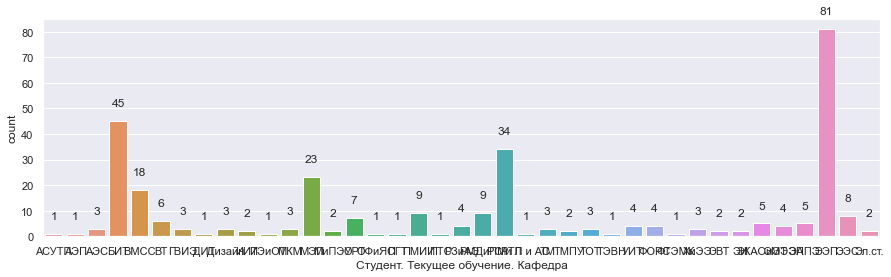

In [49]:
#for i in  valid_types_list:
sns.set(rc={'figure.figsize':(15,4)})
ax = sns.countplot(x=df_student.sort_values('Студент. Текущее обучение. Кафедра')['Студент. Текущее обучение. Кафедра'].dropna())
rects = ax.patches
labels = df_student.groupby('Студент. Текущее обучение. Кафедра')['Личность. ИД'].count()
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )

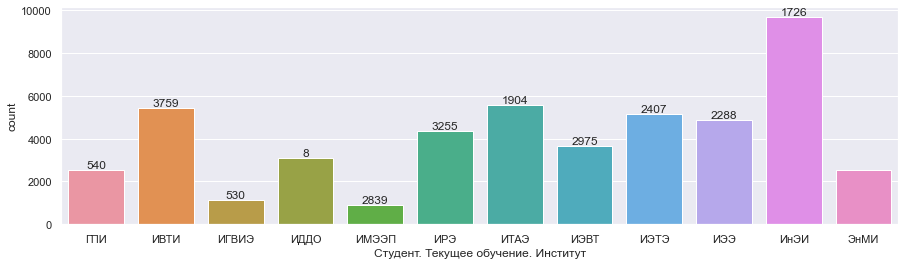

In [52]:
#for i in  valid_types_list:
sns.set(rc={'figure.figsize':(15,4)})
ax = sns.countplot(x=df_student.sort_values('Студент. Текущее обучение. Институт')['Студент. Текущее обучение. Институт'].dropna())
rects = ax.patches
labels = df_student.loc[df_student['type'] == 1].groupby('Студент. Текущее обучение. Институт')['Личность. ИД'].count()
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )

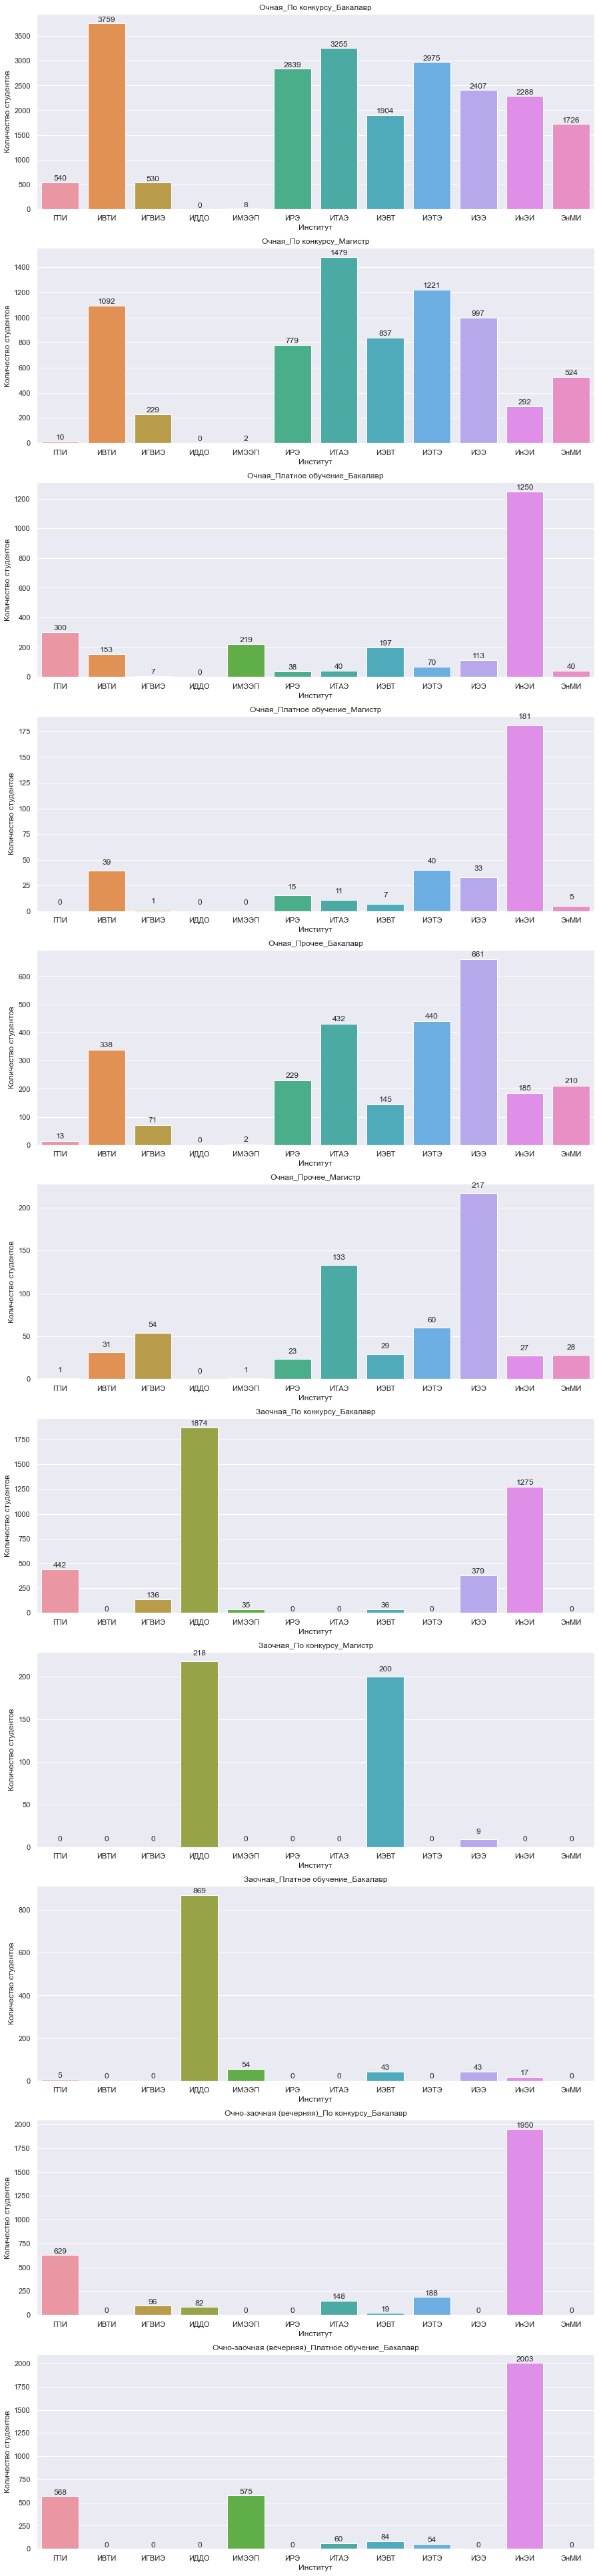

In [24]:
fig, axes = plt.subplots(len(df_valid_types.index), 1, figsize=(15, 70), sharey=False)

for i, j in zip(valid_types_list, range(0,len(df_valid_types.index))): 
    df_inst = pd.DataFrame()
    df_inst['institute'] = df_student.sort_values('Студент. Текущее обучение. Институт')['Студент. Текущее обучение. Институт'].drop_duplicates().dropna()
    df_student.loc[df_student['type'] == i].groupby(['Студент. Текущее обучение. Институт'])['Личность. ИД'].count().reset_index()
    df_inst_merge = df_inst.merge(df_student.loc[df_student['type'] == i] \
                              .groupby(['Студент. Текущее обучение. Институт'])['Личность. ИД'].count().reset_index(), \
                              left_on = 'institute', right_on = 'Студент. Текущее обучение. Институт', how = 'left').fillna(0)

    
    ax = sns.barplot(ax=axes[j],x=df_inst_merge['institute'], y = df_inst_merge['Личность. ИД'])
    axes[j].set_title(df_valid_types.loc[df_valid_types['type'] == i]['type_string'].iloc[0])
    axes[j].set_ylabel('Количество студентов')
    axes[j].set_xlabel('Институт')
    
    rects = ax.patches
    labels = df_inst_merge['Личность. ИД'].astype(int)
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
        #ax.set_xticklabels(df_student.sort_values(['type']).groupby(['type'])['type_string'].max(), rotation = 45, ha = 'right')


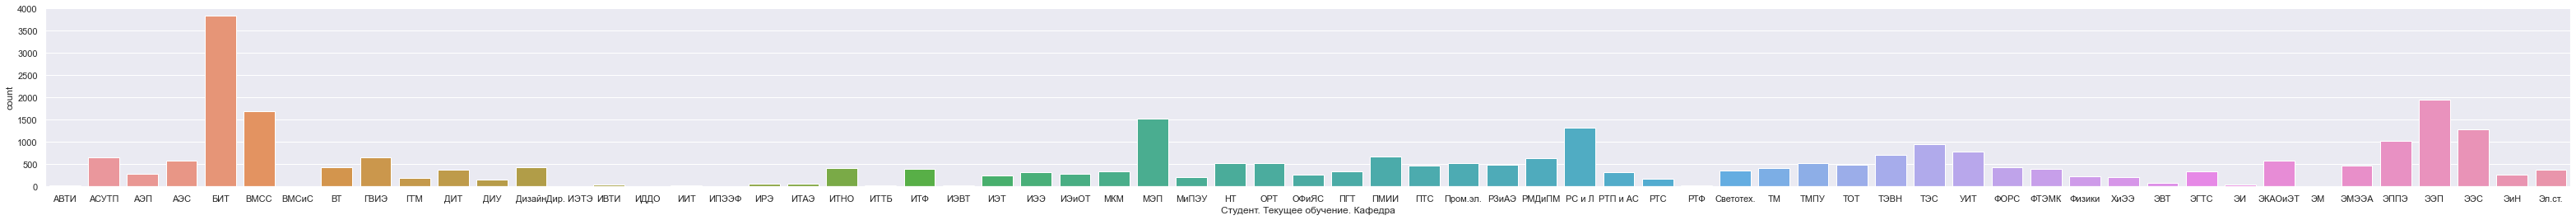

In [25]:
sns.set(rc={'figure.figsize':(55,4)})
sns.countplot(x=df_student.sort_values(by = 'Студент. Текущее обучение. Кафедра')['Студент. Текущее обучение. Кафедра'])

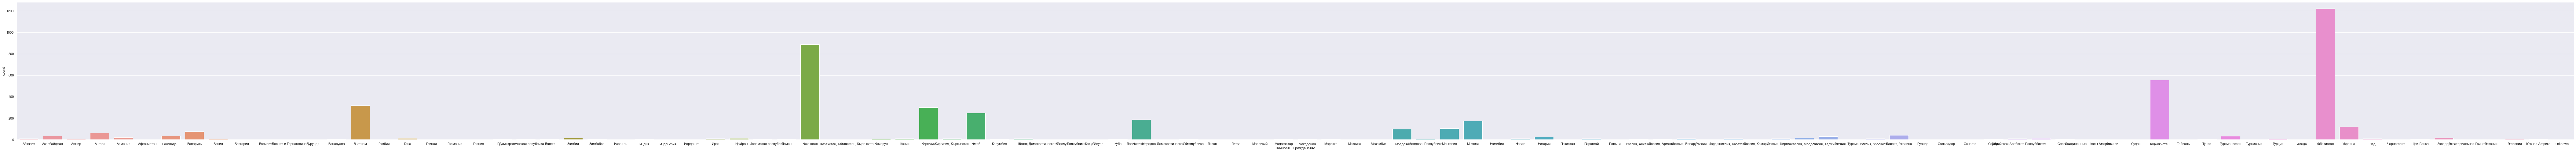

In [26]:
sns.set(rc={'figure.figsize':(150,8.27)})
df_students_no_rus = df_student.sort_values(by = 'Личность. Гражданство').loc[df_student['Личность. Гражданство'] != 'Россия']
sns.countplot(x=df_students_no_rus['Личность. Гражданство'].fillna('unknown'))

## Сумма баллов ЕГЭ


In [27]:
sns.__version__

'0.11.2'

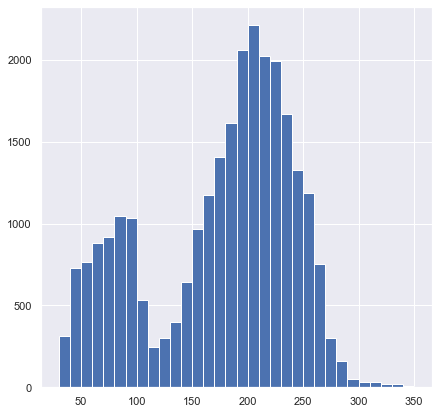

In [28]:
sns.set(rc={'figure.figsize':(7,7)})
#sns.countplot(x=df_student['Студент. Сумма баллов ЕГЭ'].fillna('unknown'))
df_student.loc[df_student['Студент. Сумма баллов ЕГЭ'].fillna(0) != 0]['Студент. Сумма баллов ЕГЭ'].hist(bins=[i for i in range(30,360,10)])

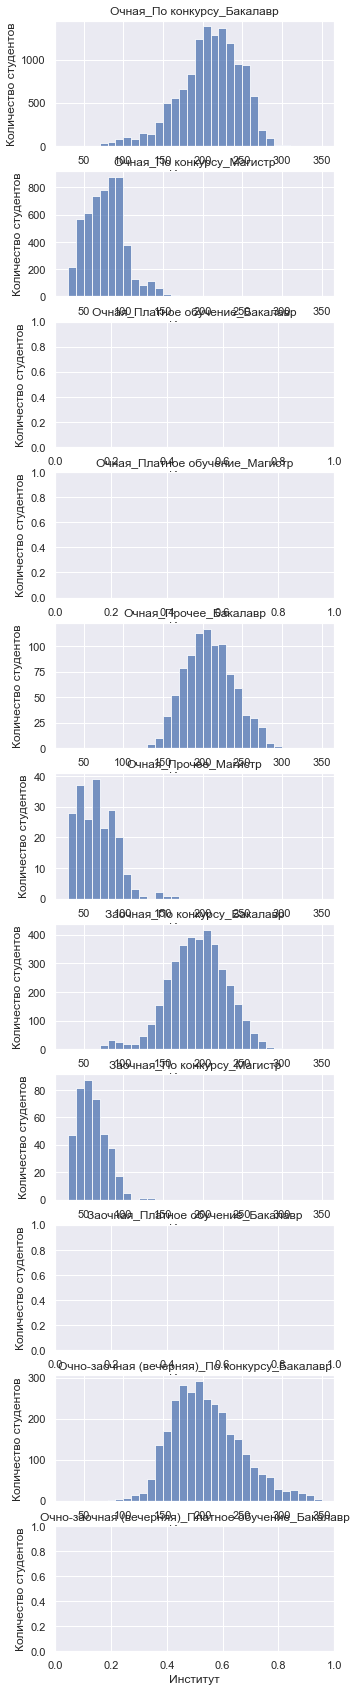

In [29]:
fig, axes = plt.subplots(len(df_valid_types.index), 1, figsize=(5, 30))

for i, j in zip(valid_types_list, range(0,len(df_valid_types.index))):   
    
    sns.histplot(df_student.loc[(df_student['Студент. Сумма баллов ЕГЭ'].fillna(0) != 0) & (df_student['type'] == i)]['Студент. Сумма баллов ЕГЭ'],bins=[i for i in range(30,360,10)],ax=axes[j])
    axes[j].set_title(df_valid_types.loc[df_valid_types['type'] == i]['type_string'].iloc[0])
    axes[j].set_ylabel('Количество студентов')
    axes[j].set_xlabel('Институт')
    
   

Text(0.5, 0.98, 'Очная_По конкурсу_Бакалавр')

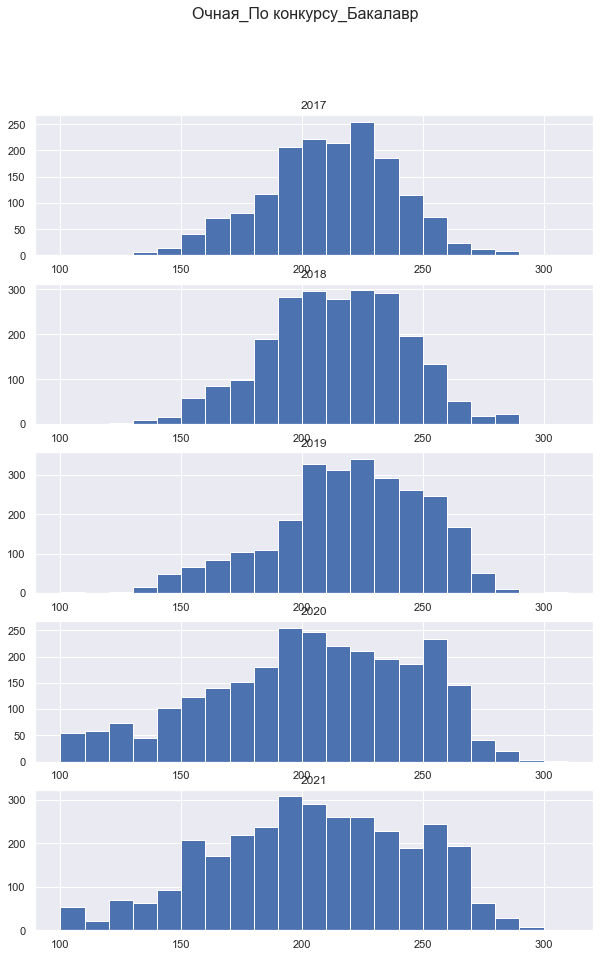

In [30]:
#df_student.groupby('Студент. Год поступления')['Студент. Сумма баллов ЕГЭ'].hist()

type = 1

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

i = 0

for  year in ([2017,2018,2019,2020,2021]):
    #print(year)
    df_student.loc[(df_student['Студент. Год поступления'] == year) & (df_student['type'] == type) ].groupby('Студент. Год поступления')['Студент. Сумма баллов ЕГЭ'].hist(ax=axes[i], bins=[i for i in range(100,320,10)])
    axes[i].set_title(year)
    i+=1
fig.suptitle(df_valid_types.loc[df_valid_types['type'] == type]['type_string'].min(), fontsize=16)


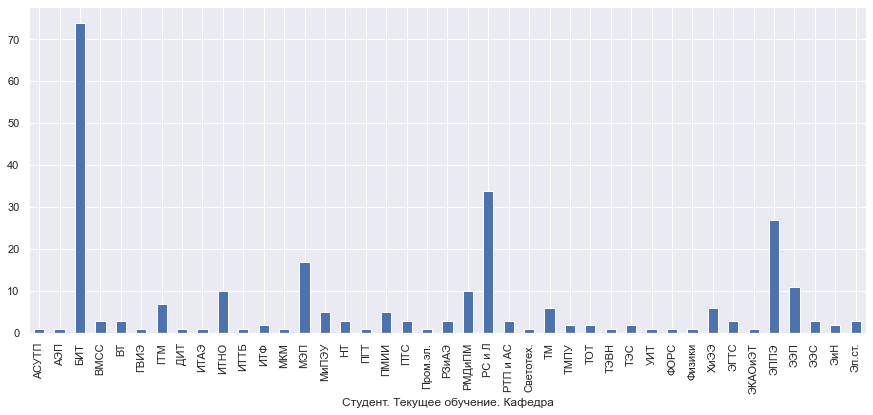

In [31]:
#Распределение студентов с ЕГЭ <150 по кафедрам 

#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 15))

df_student.sort_values('Студент. Текущее обучение. Кафедра').loc[(df_student['Студент. Год поступления'] >= 2017) & \
                (df_student['type'] == 1)  &\
                (df_student['Студент. Сумма баллов ЕГЭ'] < 150) & \
                #(df_student['Студент. Текущее обучение. Статус обучения']  == 'Обучается') &\
                (df_student['Студент. Тип гражданства'] == 'Гражданин РФ')] \
    .groupby('Студент. Текущее обучение. Кафедра')['Студент. Сумма баллов ЕГЭ'].count().plot.bar(figsize=(15,6), )



### Формируем выборку для визуализации

In [32]:
df_student.dtypes

df_student_encoded = df_student[["Личность. Пол", "Личность. Гражданство", "Студент. Сумма баллов ЕГЭ" ]]
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df_student_encoded["Личность. Гражданство"] = ord_enc.fit_transform(df_student[["Личность. Гражданство"]].fillna('unknown'))
df_student_encoded["Личность. Пол"] = ord_enc.fit_transform(df_student[["Личность. Пол"]].fillna('unknown'))
df_student_encoded.head(100)

,Личность. Пол,Личность. Гражданство,Студент. Сумма баллов ЕГЭ
0,1.0,62.0,70.0
1,1.0,62.0,64.0
2,1.0,15.0,100.0
3,1.0,62.0,80.0
4,1.0,62.0,66.0
...,...,...,...
96,0.0,69.0,237.0
97,0.0,69.0,115.0
98,0.0,69.0,237.0
99,1.0,69.0,NaN


MDS: 16 sec
t-SNE: 8 sec


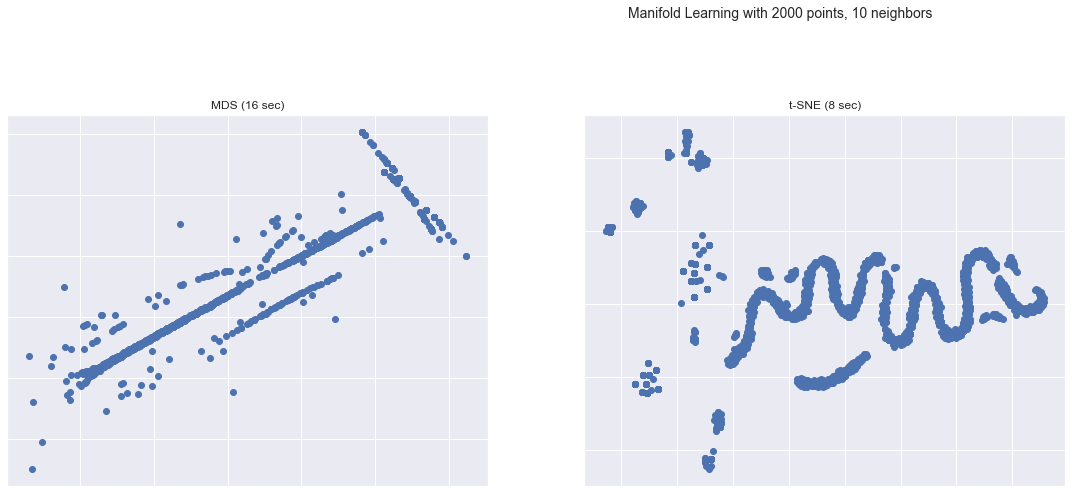

In [33]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 2000

n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(50, 15))
fig.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (n_points, n_neighbors), fontsize=14
)

# Add 3d scatter plot
#ax = fig.add_subplot(251, projection="3d")
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
#ax.view_init(4, -72)


LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver="auto",
)

methods = OrderedDict()
#methods["LLE"] = LLE(method="standard")
#methods["LTSA"] = LLE(method="ltsa")
#methods["Hessian LLE"] = LLE(method="hessian")
#methods["Modified LLE"] = LLE(method="modified")
#methods["Isomap"] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods["MDS"] = manifold.MDS(n_components, max_iter=100, n_init=1)
#methods["SE"] = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
methods["t-SNE"] = manifold.TSNE(n_components=n_components, init="pca", random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(df_student_encoded.fillna(0).head(n_points))
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

plt.show()

## Выборка оценок

In [34]:
df_mark

,Студент. ИД,Студент. Номер зачётнй книжки,Семестр обучения студента,Год обучения,Семестр. Номер,Семестр. Название,Дисциплина,Тип ПА,Оценка,Оценка. Код,Дата экзамена,Преподаватель ФИО
0,{9849CA5B-987E-E611-80C0-005056BEEEDD},0020101657,2,2010 - 2011,2,Весенний,Физическая культура,Дифф. зачёт,Хорошо,4.0,2011-06-09 00:00:00,NaN
1,{EFF82614-987E-E611-80C0-005056BEEEDD},0020082073,5,2010 - 2011,1,Осенний,Статистика,Экзамен,Хорошо,4.0,2011-01-10 00:00:00,NaN
2,{FC316ECC-977E-E611-80C0-005056BEEEDD},0020070598,7,2010 - 2011,1,Осенний,Экономика,Дифф. зачёт,Хорошо,4.0,2011-03-01 00:00:00,NaN
3,{612261D8-977E-E611-80C0-005056BEEEDD},0020070719,7,2010 - 2011,1,Осенний,Экономика,Дифф. зачёт,Отлично,5.0,2011-03-01 00:00:00,NaN
4,{B802D255-987E-E611-80C0-005056BEEEDD},0020101625,1,2010 - 2011,1,Осенний,Физическая культура,Дифф. зачёт,Хорошо,4.0,2011-01-10 10:15:22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3267756,{BC6986E5-3901-EC11-80D6-005056BEEEDD},2.02139e+07,1,2021 - 2022,1,Осенний,Методы цифровой обработки информации,Экзамен,Хорошо,4.0,2022-01-17 00:00:00,Шатохин А.А.
3267757,{0D22CF37-1800-EC11-80D6-005056BEEEDD},2.02125e+07,1,2021 - 2022,1,Осенний,Высшая математика,Экзамен,Удовл.,3.0,2022-01-27 00:00:00,Подкопаева В.А.
3267758,{E974398E-1600-EC11-80D6-005056BEEEDD},2.02108e+07,1,2021 - 2022,1,Осенний,Высшая математика,Экзамен,Хорошо,4.0,2022-01-27 00:00:00,Подкопаева В.А.
3267759,{E8A8F7DC-1600-EC11-80D6-005056BEEEDD},2.02111e+07,1,2021 - 2022,1,Осенний,Высшая математика,Экзамен,Хорошо,4.0,2022-01-27 00:00:00,Подкопаева В.А.


In [35]:
print(df_mark.isna().sum())
#del df_mark['Преподаватель ФИО']

Студент. ИД                            0
Студент. Номер зачётнй книжки         76
Семестр обучения студента             35
Год обучения                          35
Семестр. Номер                        35
Семестр. Название                    149
Дисциплина                           149
Тип ПА                               263
Оценка                               263
Оценка. Код                          263
Дата экзамена                        263
Преподаватель ФИО                2862498
dtype: int64


In [36]:
df_mark.loc[(df_mark['Семестр. Название'] == "Осенний"), 'Семестр. Название'] = "_Осенний"

In [37]:
df_mark['Оценка'].unique()

array(['Хорошо', 'Отлично', 'Удовл.', 'Неудовл.', 'Недопуск',
       'Академ. отпуск', 'Продление', 'Сдан досрочно', 'Отчислен',
       'Неявка', 'Не сдаёт', 'Зачтено', 'Перезачет', 'Не зачтено',
       'Допущен', 'Не допущен', nan, 'Удален'], dtype=object)

In [38]:
df_mark_only_marks =  df_mark.loc[df_mark['Оценка. Код']  <= 5 ]


In [1]:
df_mark.loc[df_mark['Оценка. Код']  == 0 ]

NameError: name 'df_mark' is not defined

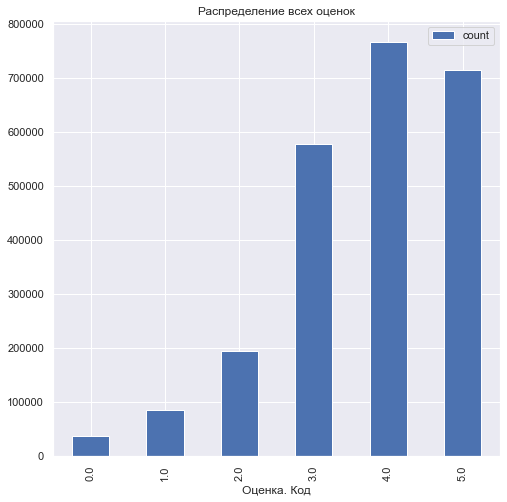

In [39]:

#df_mark_only_marks.loc[df_mark_only_marks['Год обучения'] == '2010 - 2011'].groupby(['Оценка. Код'])['Оценка'].count()
df = pd.DataFrame({'Оценка. Код': df_mark_only_marks.sort_values(by = ['Оценка. Код'])['Оценка. Код'].unique(), 'count': df_mark_only_marks.groupby(['Оценка. Код'])['Оценка'].count() })
df.plot.bar('Оценка. Код', title = 'Распределение всех оценок', figsize=(8,8))

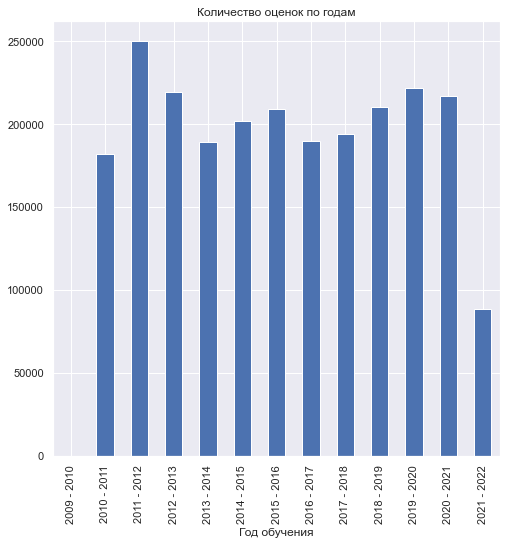

In [40]:
#Количество оценок по годам
df_mark_only_marks.groupby('Год обучения')['Оценка'].count().plot.bar(title = 'Количество оценок по годам', figsize=(8,8))

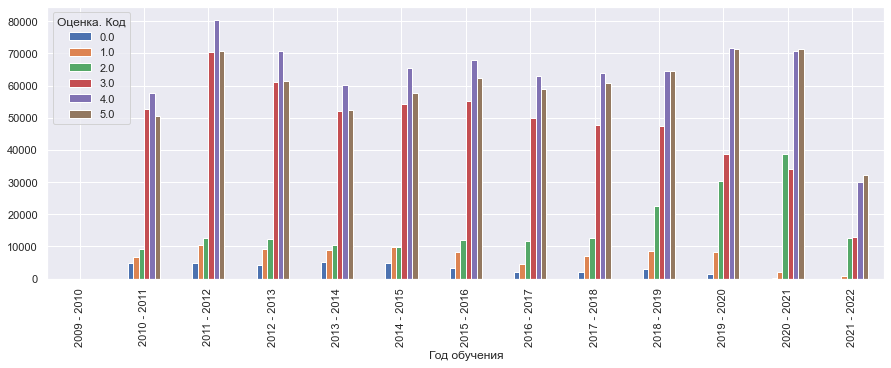

In [67]:
df_mark_only_marks.sort_values(by = ['Оценка. Код']).groupby([ 'Год обучения', 'Оценка. Код']).size().unstack().plot(kind='bar',figsize=(15,5))


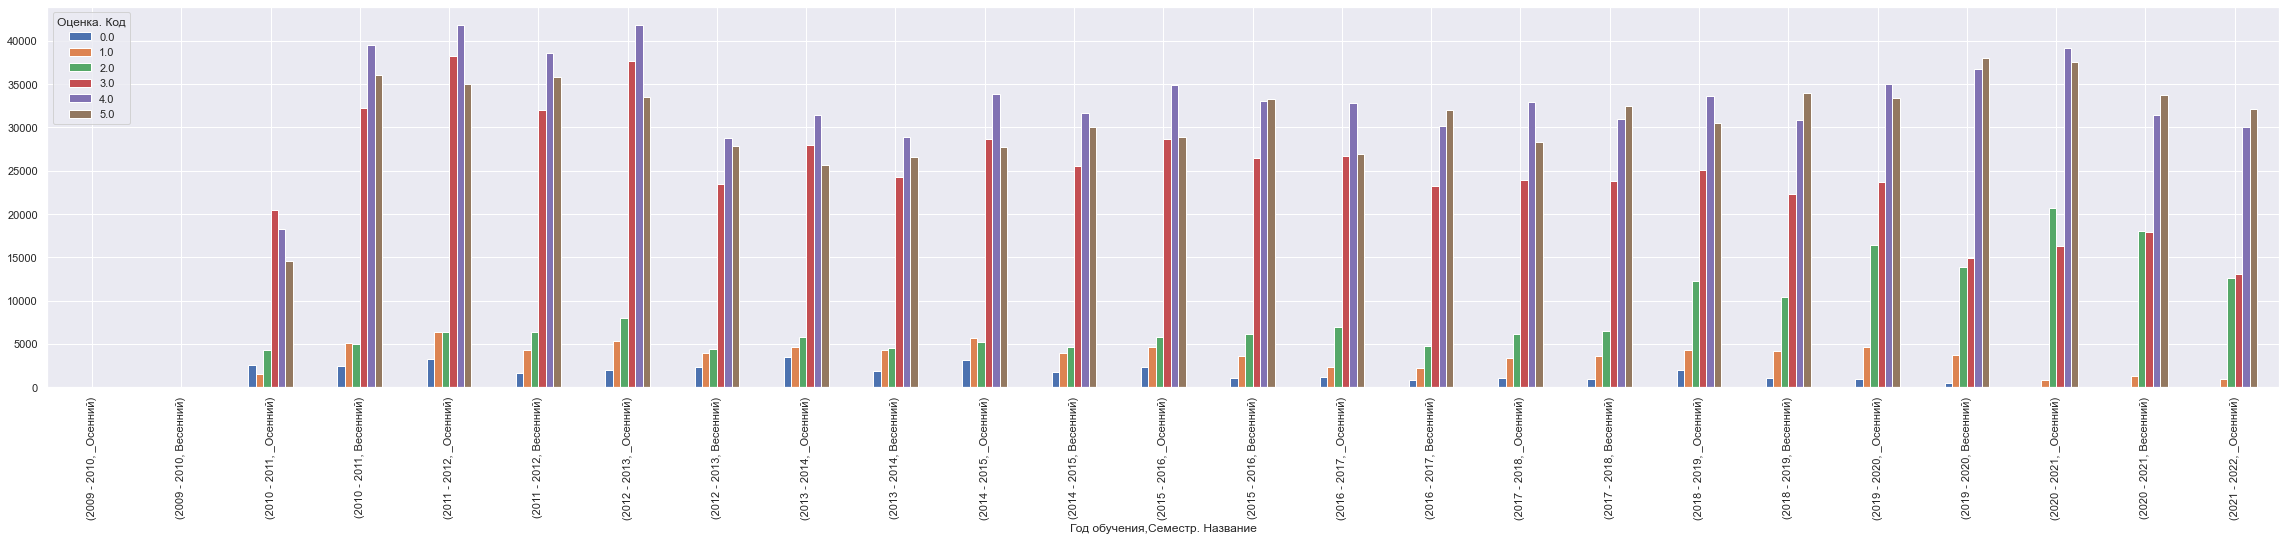

In [42]:
d = df_mark_only_marks.sort_values(by = ['Оценка. Код', 'Семестр. Название'], ascending = [True, False]).groupby([ 'Год обучения', 'Семестр. Название', 'Оценка. Код']).size().unstack().plot(kind='bar',figsize=(40,7))


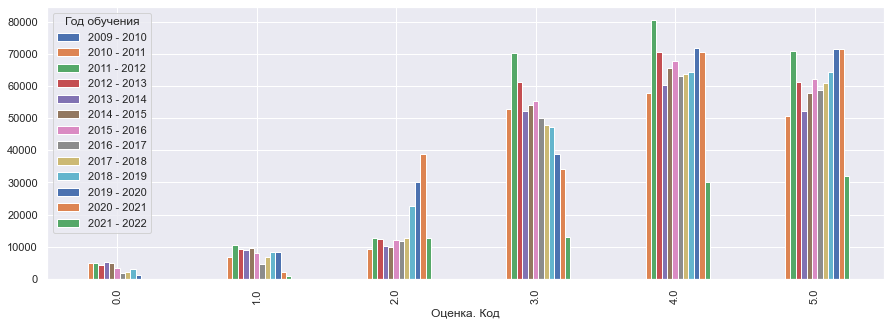

In [43]:

df_mark_only_marks.sort_values(by = ['Оценка. Код']).groupby(['Оценка. Код', 'Год обучения']).size().unstack().plot(kind='bar',figsize=(15,5))
#df = df_mark_only_marks.sort_values(by = ['Оценка. Код']).groupby(['Год обучения','Оценка. Код']).size()#.plot.bar()


In [44]:
#df_mark_only_marks['Год обучения'].unique()
#i = 1
#fig = plt.figure(figsize=(20, 15))
#for  year in (df_mark_only_marks['Год обучения'].unique()):
#    print(year)
    
#    ax = fig.add_subplot(3, 5, i)
#    ax.bar(df_mark_only_marks['Оценка. Код'].unique(), df_mark_only_marks.loc[df_mark_only_marks['Год обучения'] == year].groupby(['Оценка. Код'])['Оценка'].count()
# )
#    i+=1
#    ax.set_title(year)



## Объединение оценок и студентов

In [45]:
df_merge_student_marks = pd.merge(df_mark, df_student)


In [46]:
df_merge_student_marks

,Студент. ИД,Студент. Номер зачётнй книжки,Семестр обучения студента,Год обучения,Семестр. Номер,Семестр. Название,Дисциплина,Тип ПА,Оценка,Оценка. Код,Дата экзамена,Преподаватель ФИО,№,Личность. ИД,Личность. Фамилия,Личность. Имя,Личность. Отчество,Личность. Пол,Личность. Дата рождения,Личность. Гражданство,Личность. Местро рождения. Регион,Личность. Местро рождения. Страна,Личность. Место жительства. Регион,Личность. Место жительства. Страна,Личность. Место жительства. Постоянная прописка. Регион,Личность. Место жительства. Постоянная прописка. Страна,Студент. Номер зачётной книжки,Студент. Дата поступления,Студент. Год поступления,Студент. Дата окончания (ожидаемая),Студент. Дата отчисления,Студент. Тип гражданства,Студент. Категория поступления,Студент. Сумма баллов ЕГЭ,Студент. Текущее обучение. Учебная группа. Курс,Студент. Текущее обучение. Семестр обучения,Студент. Текущее обучение. Учебная группа,Студент. Текущее обучение. Институт,Студент. Текущее обучение. Кафедра,Студент. Текущее обучение. Статус обучения,Студент. Текущее обучение. Форма обучения,Студент. Текущее обучение. Квалификация,Студент. Текущее обучение. Направление,Студент. Текущее обучение. Причина отчисления,Студент. Текущее обучение. Причина попадания в статус,Студент. Первое обучение. Учебная группа,Студент. Первое обучение. Институт,Студент. Первое обучение. Кафедра,Студент. Первое обучение. Статус обучения,Студент. Первое обучение. Форма обучения,Студент. Первое обучение. Квалификация,Студент. Первое обучение. Направление,Студент. Категория поступления укрупненно,type_string,type
0,{C0E28E8B-987E-E611-80C0-005056BEEEDD},0020079739,9,2011 - 2012,1,_Осенний,Применение нанотехнологий,Дифф. зачёт,Хорошо,4.0,2011-12-22 08:13:36,NaN,35907,{D50E9039-867E-E611-80C0-005056BEEEDD},Коспанов,Арман,Нургильдиевич,Мужской,09.03.1985,Казахстан,NaN,NaN,NaN,NaN,NaN,NaN,0020079739,01.09.2011,2011,04.07.2013,04.07.2013,Иностранец,По конкурсу,NaN,15.0,4.0,ФП-06-07,ИЭВТ,NaN,Завершил обучение,Очная,Магистр,13.03.01 (ФГОС) Теплоэнергетика и теплотехника,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу,Очная_По конкурсу_Магистр,2
1,{C0E28E8B-987E-E611-80C0-005056BEEEDD},0020079739,9,2011 - 2012,1,_Осенний,Принципы эффективного управления технологическ...,Дифф. зачёт,Хорошо,4.0,2011-12-28 11:47:03,NaN,35907,{D50E9039-867E-E611-80C0-005056BEEEDD},Коспанов,Арман,Нургильдиевич,Мужской,09.03.1985,Казахстан,NaN,NaN,NaN,NaN,NaN,NaN,0020079739,01.09.2011,2011,04.07.2013,04.07.2013,Иностранец,По конкурсу,NaN,15.0,4.0,ФП-06-07,ИЭВТ,NaN,Завершил обучение,Очная,Магистр,13.03.01 (ФГОС) Теплоэнергетика и теплотехника,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу,Очная_По конкурсу_Магистр,2
2,{C0E28E8B-987E-E611-80C0-005056BEEEDD},0020079739,9,2011 - 2012,1,_Осенний,Принципы эффективного управления технологическ...,Экзамен,Отлично,5.0,2012-01-23 00:00:00,NaN,35907,{D50E9039-867E-E611-80C0-005056BEEEDD},Коспанов,Арман,Нургильдиевич,Мужской,09.03.1985,Казахстан,NaN,NaN,NaN,NaN,NaN,NaN,0020079739,01.09.2011,2011,04.07.2013,04.07.2013,Иностранец,По конкурсу,NaN,15.0,4.0,ФП-06-07,ИЭВТ,NaN,Завершил обучение,Очная,Магистр,13.03.01 (ФГОС) Теплоэнергетика и теплотехника,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу,Очная_По конкурсу_Магистр,2
3,{C0E28E8B-987E-E611-80C0-005056BEEEDD},0020079739,9,2011 - 2012,1,_Осенний,Экологическая безопасность,Дифф. зачёт,Отлично,5.0,2011-12-27 08:18:58,NaN,35907,{D50E9039-867E-E611-80C0-005056BEEEDD},Коспанов,Арман,Нургильдиевич,Мужской,09.03.1985,Казахстан,NaN,NaN,NaN,NaN,NaN,NaN,0020079739,01.09.2011,2011,04.07.2013,04.07.2013,Иностранец,По конкурсу,NaN,15.0,4.0,ФП-06-07,ИЭВТ,NaN,Завершил обучение,Очная,Магистр,13.03.01 (ФГОС) Теплоэнергетика и теплотехника,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,По конкурсу,Очная_По конкурсу_Магистр,2
4,{C0E28E8B-987E-E611-80C0-005056BEEEDD},0020079739,9,2011 - 2012,1,_Осенний,Энерготехн.комплекс пром.предпр.,Дифф. зачёт,Отлично,5.0,2011-12-20 08:14:40,NaN,35907,{D50E9039-867E-E611-80C0-005056BEEEDD},Коспанов,Арман,Нургильдиеви

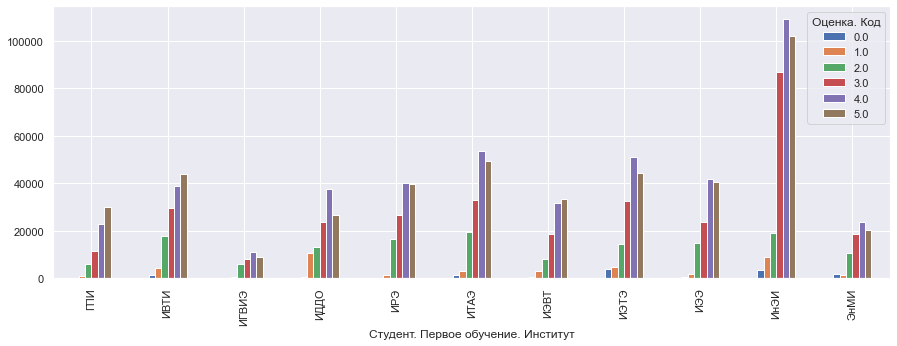

In [70]:
df_merge_student_marks.sort_values(by = ['Оценка. Код']).loc[(df_merge_student_marks['Оценка. Код']  <= 5) & (df_merge_student_marks['type'] >0)  ].groupby(['Студент. Первое обучение. Институт',  'Оценка. Код']).size().unstack().plot(kind='bar',figsize=(15,5))


## Строим распределение оценок по типам студентов

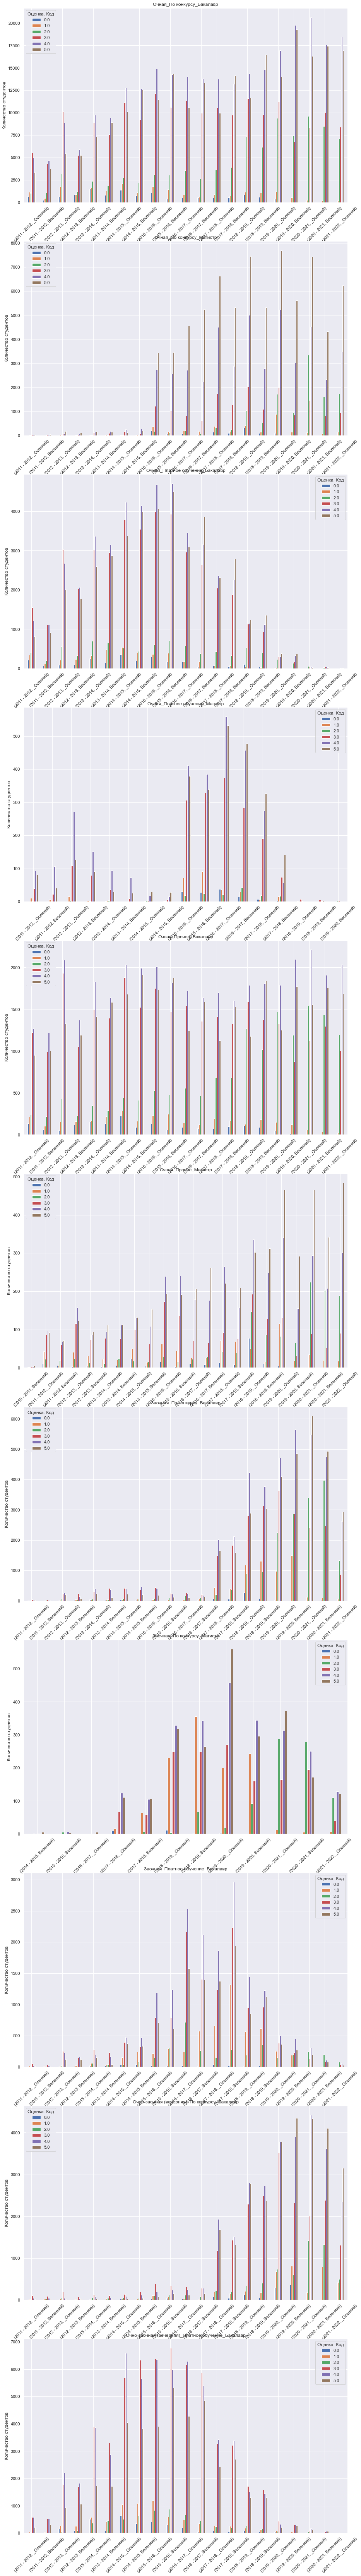

In [48]:
#type = 1
fig, axes = plt.subplots(len(df_valid_types.index), 1, figsize=(15, 120), sharey=False)
for i, j in zip(valid_types_list, range(0,len(df_valid_types.index))): 
    ax = df_merge_student_marks.sort_values(by = ['Оценка. Код', 'Семестр. Название'], ascending = [True, False]) \
                       .loc[(df_merge_student_marks['type'] == i) & \
                         ( df_merge_student_marks['Оценка. Код'] <= 5)] \
                     .groupby(['Год обучения', 'Семестр. Название', 'Оценка. Код']).size().unstack().plot(kind='bar', ax=axes[j])
    
    
  #  df_mark_only_marks.sort_values(by = ['Оценка. Код', 'Семестр. Название'], ascending = [True, False]).groupby([ 'Год обучения', 'Семестр. Название', 'Оценка. Код']).size().unstack().plot(kind='bar',figsize=(40,7))
  #  ax = sns.barplot(y=df_merge_student_marks.sort_values(by = ['Оценка. Код']) \
  #                      .loc[(df_merge_student_marks['type'] == i) & \
  #                         ( df_merge_student_marks['Оценка. Код'] <= 5)] \
  #                      .groupby([ 'Год обучения', 'Оценка. Код']).size().unstack(),   ax=axes[j])
    
    #ax=axes[j],x=df_inst_merge['institute'], y = df_inst_merge['Личность. ИД']
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        # ha = 'right'

    axes[j].set_title(df_valid_types.loc[df_valid_types['type'] == i]['type_string'].iloc[0])
    axes[j].set_ylabel('Количество студентов')
    axes[j].set_xlabel('')
   
   

In [135]:

df_selected_valid_types = df_valid_types[df_valid_types['type_string'].str.contains('Очная', case=True, na=False) & \
                                         df_valid_types['type_string'].str.contains('Магистр', case=True, na=False)]
df_selected_valid_types

,type,type_string
type,,
2,2,Очная_По конкурсу_Магистр
4,4,Очная_Платное обучение_Магистр
6,6,Очная_Прочее_Магистр


In [112]:
df_student[df_student['type_string'].str.contains('Очная', case=False, na=False)].groupby(['type_string',.str.contains('Очна, case=False, na=Falseя') 'Студент. Год поступления'])['type'].count()

type_string                                Студент. Год поступления
Заочная_Платное обучение_Бакалавр          2011                         66
                                           2012                          9
                                           2013                         27
                                           2014                        209
                                           2015                        364
                                                                      ... 
Очно-заочная (вечерняя)_Прочее_Бакалавр    2019                          4
                                           2020                          8
                                           2021                         10
Очно-заочная (вечерняя)_Прочее_Магистр     2021                          2
Очно-заочная (вечерняя)_Прочее_Специалист  2011                          2
Name: type, Length: 170, dtype: int64

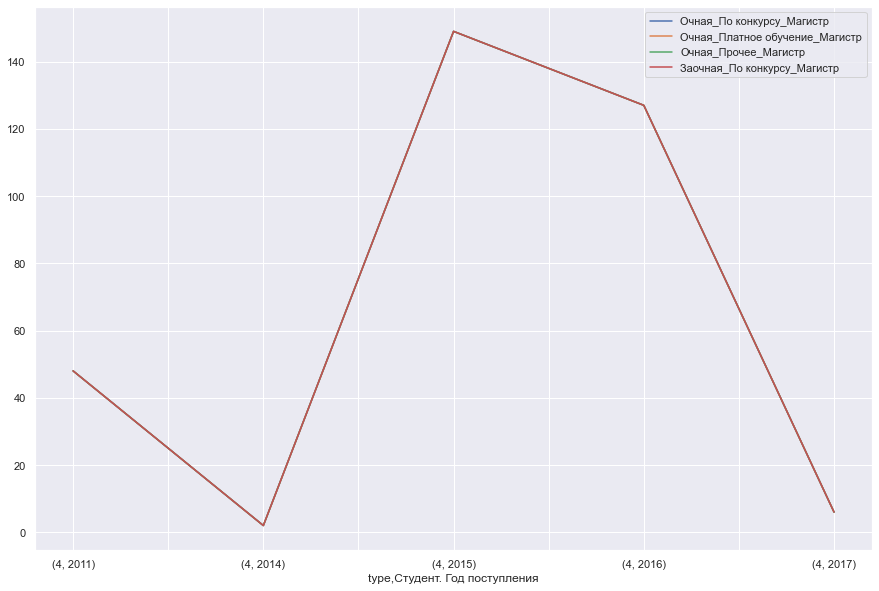

In [141]:
#Смотрим, почему есть провал в оценках начиная с 2018 года - с этого времени резко падает количество поступивших на платное

df_selected_valid_types = df_valid_types[df_valid_types['type_string'].str.contains('', case=True, na=False) & \
                                         df_valid_types['type_string'].str.contains('Магистр', case=True, na=False)]

fig, ax = plt.subplots()
for i, j in zip(df_selected_valid_types['type'], range(0,len(df_selected_valid_types.index))):
    df_student.loc[df_student['type'] == 4 ].groupby(['type', 'Студент. Год поступления'])['type'].count().plot(figsize=(15,10),ax=ax)
ax.legend(df_selected_valid_types['type_string']);


In [49]:
dd = df_merge_student_marks.sort_values(by = ['Оценка. Код']).loc[df_merge_student_marks['Оценка. Код']  <= 5 ].groupby(['Студент. Первое обучение. Институт', 'Оценка. Код'])

In [50]:
d=dd.size().reset_index()

In [51]:
d.groupby('Студент. Первое обучение. Институт').max().reset_index()[0]

0      30020
1      43999
2      10991
3      37392
4      40046
5      53406
6      33325
7      51038
8      41792
9     109217
10     23768
Name: 0, dtype: int64

In [52]:
 d.groupby('Студент. Первое обучение. Институт').max().reset_index()

,Студент. Первое обучение. Институт,Оценка. Код,0
0,ГПИ,5.0,30020
1,ИВТИ,5.0,43999
2,ИГВИЭ,5.0,10991
3,ИДДО,5.0,37392
4,ИРЭ,5.0,40046
5,ИТАЭ,5.0,53406
6,ИЭВТ,5.0,33325
7,ИЭТЭ,5.0,51038
8,ИЭЭ,5.0,41792
9,ИнЭИ,5.0,109217


In [53]:
df_inst_marks_scaled = pd.merge(dd.size().reset_index(), d.groupby('Студент. Первое обучение. Институт').max().reset_index(), left_on='Студент. Первое обучение. Институт', right_on='Студент. Первое обучение. Институт')

In [54]:
df_inst_marks_scaled  = df_inst_marks_scaled.assign (sum_scaled = df_inst_marks_scaled['0_x'] / df_inst_marks_scaled['0_y'] )
df_inst_marks_scaled

,Студент. Первое обучение. Институт,Оценка. Код_x,0_x,Оценка. Код_y,0_y,sum_scaled
0,ГПИ,0.0,221,5.0,30020,0.007362
1,ГПИ,1.0,727,5.0,30020,0.024217
2,ГПИ,2.0,5769,5.0,30020,0.192172
3,ГПИ,3.0,11531,5.0,30020,0.384111
4,ГПИ,4.0,22796,5.0,30020,0.759360
...,...,...,...,...,...,...
61,ЭнМИ,1.0,1475,5.0,23768,0.062058
62,ЭнМИ,2.0,10520,5.0,23768,0.442612
63,ЭнМИ,3.0,18421,5.0,23768,0.775034
64,ЭнМИ,4.0,23768,5.0,23768,1.000000


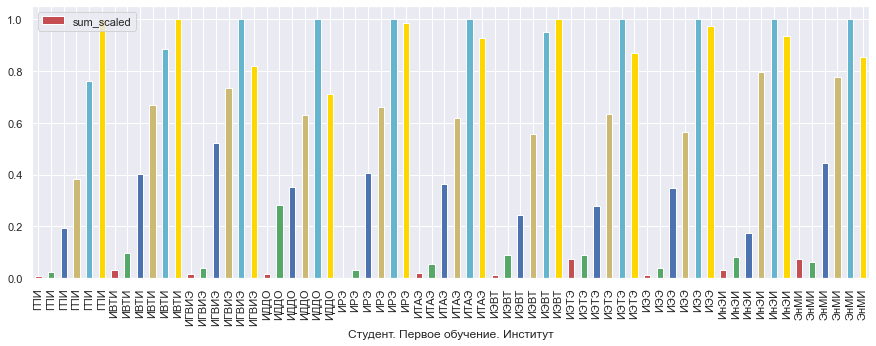

In [55]:

color_list = ['r','g','b', 'y', 'c', 'gold']


df_inst_marks_scaled.plot(kind = 'bar', x = 'Студент. Первое обучение. Институт', y = 'sum_scaled',figsize=(15,5), color=color_list ) 

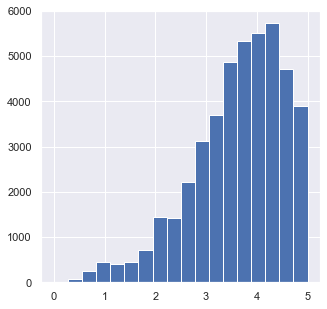

In [56]:
df_merge_student_marks.loc[df_merge_student_marks['Оценка. Код'] <= 5] \
    .groupby('Студент. ИД')['Оценка. Код'].mean().hist(figsize=(5,5), bins = 18)




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8B5290EB0>,
      dtype=object)

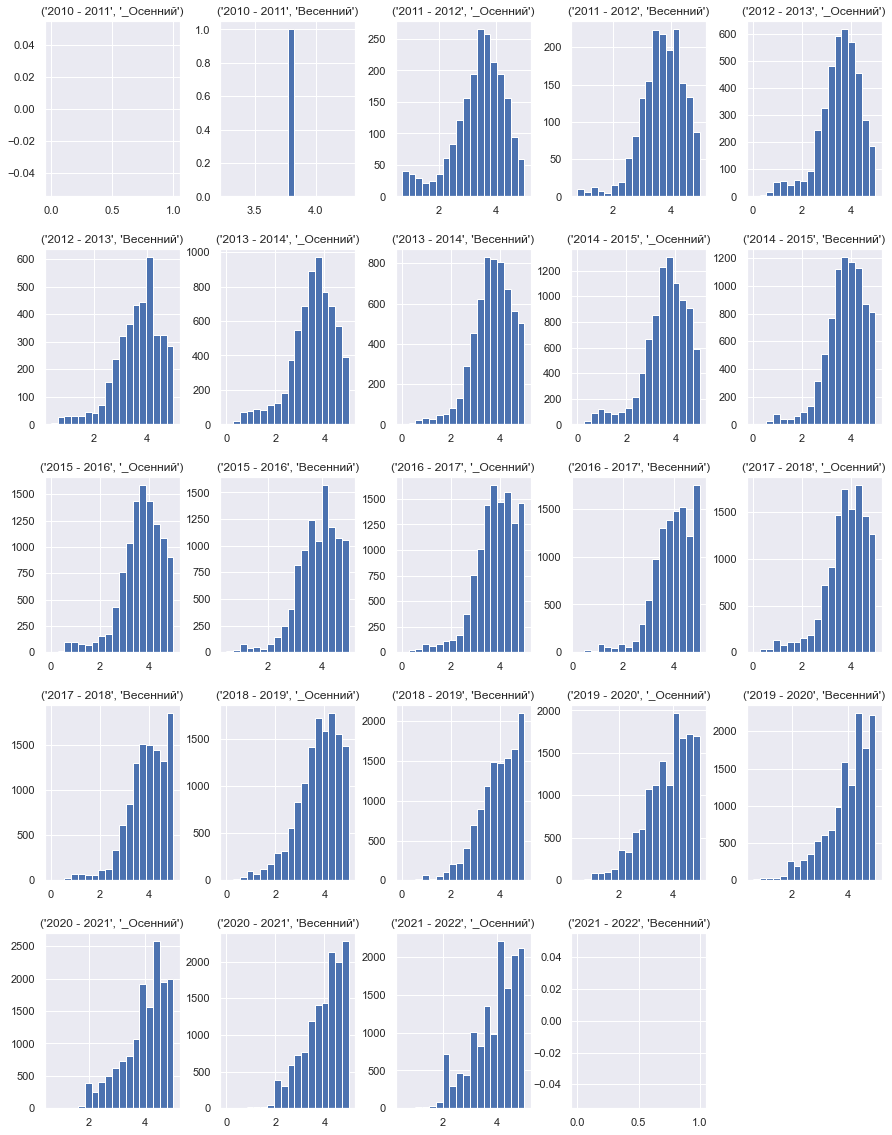

In [57]:
#Разброс средних баллов по годам
df_merge_student_marks.loc[(df_merge_student_marks['Оценка. Код'] <= 5)] \
    .groupby(['Студент. ИД', 'Семестр. Название', 'Год обучения' ])['Оценка. Код'] \
    .mean().unstack().unstack().hist(bins=18, figsize=(15,20))

In [58]:
#df_student.groupby(['Студент. Год поступления'])['Студент. Сумма баллов ЕГЭ'].mean()
df_student.loc[(df_student['Студент. Год поступления'] > 2016) ]

,№,Личность. ИД,Личность. Фамилия,Личность. Имя,Личность. Отчество,Личность. Пол,Личность. Дата рождения,Личность. Гражданство,Личность. Местро рождения. Регион,Личность. Местро рождения. Страна,Личность. Место жительства. Регион,Личность. Место жительства. Страна,Личность. Место жительства. Постоянная прописка. Регион,Личность. Место жительства. Постоянная прописка. Страна,Студент. ИД,Студент. Номер зачётной книжки,Студент. Дата поступления,Студент. Год поступления,Студент. Дата окончания (ожидаемая),Студент. Дата отчисления,Студент. Тип гражданства,Студент. Категория поступления,Студент. Сумма баллов ЕГЭ,Студент. Текущее обучение. Учебная группа. Курс,Студент. Текущее обучение. Семестр обучения,Студент. Текущее обучение. Учебная группа,Студент. Текущее обучение. Институт,Студент. Текущее обучение. Кафедра,Студент. Текущее обучение. Статус обучения,Студент. Текущее обучение. Форма обучения,Студент. Текущее обучение. Квалификация,Студент. Текущее обучение. Направление,Студент. Текущее обучение. Причина отчисления,Студент. Текущее обучение. Причина попадания в статус,Студент. Первое обучение. Учебная группа,Студент. Первое обучение. Институт,Студент. Первое обучение. Кафедра,Студент. Первое обучение. Статус обучения,Студент. Первое обучение. Форма обучения,Студент. Первое обучение. Квалификация,Студент. Первое обучение. Направление,Студент. Категория поступления укрупненно,type_string,type
0,1,{9E02B810-0318-EC11-80D6-005056BEEEDD},NaN,Аунг Пьё,NaN,Мужской,28.05.1995,Мьянма,NaN,NaN,Город Москва,NaN,NaN,Мьянма,{3667532E-0318-EC11-80D6-005056BEEEDD},0020218106,01.09.2021,2021,31.08.2023,NaN,Иностранец,По конкурсу,70.0,1.0,1.0,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
1,2,{C9C33E91-1FFD-EA11-80D4-005056BEEEDD},NaN,Аунг Че Мин,NaN,Мужской,02.05.1994,Мьянма,МЬЯНМА,NaN,Москва г,Россия,NaN,NaN,{A543EDB6-1FFD-EA11-80D4-005056BEEEDD},0020209686,01.09.2020,2020,31.08.2023,NaN,Иностранец,По конкурсу,64.0,1.0,1.0,А-13м-21,ИВТИ,ПМИИ,Обучается,Очная,Магистр,01.04.02 Прикладная математика и информатика,NaN,NaN,А-13м-21,ИВТИ,ПМИИ,Обучается,Очная,Магистр,01.04.02 Прикладная математика и информатика,По конкурсу,Очная_По конкурсу_Магистр,2
2,3,{09D38C2D-F126-EC11-80D6-005056BEEEDD},NaN,До Хай Киен,NaN,Мужской,17.02.2002,Вьетнам,NaN,NaN,NaN,Вьетнам,NaN,Вьетнам,{535DA04A-F126-EC11-80D6-005056BEEEDD},0020218788,01.09.2021,2021,31.08.2025,NaN,Иностранец,По конкурсу,100.0,1.0,1.0,Ав-12-21,ИВТИ,ВМСС,Академический отпуск,Очная,Бакалавр,09.03.01 Информатика и вычислительная техника,NaN,NaN,Ав-12-21,ИВТИ,ВМСС,Обучается,Очная,Бакалавр,09.03.01 Информатика и вычислительная техника,По конкурсу,Очная_По конкурсу_Бакалавр,1
3,4,{A802B810-0318-EC11-80D6-005056BEEEDD},NaN,Зин Вин Хту,NaN,Мужской,10.06.1996,Мьянма,NaN,NaN,Город Москва,NaN,NaN,Мьянма,{3C67532E-0318-EC11-80D6-005056BEEEDD},0020218108,01.09.2021,2021,31.08.2023,NaN,Иностранец,По конкурсу,80.0,1.0,1.0,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-21,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
4,5,{CEC33E91-1FFD-EA11-80D4-005056BEEEDD},NaN,Зин Ко,NaN,Мужской,04.07.1994,Мьянма,Республика Союз Мьянма,NaN,Москва г,Россия,NaN,NaN,{A843EDB6-1FFD-EA11-80D4-005056BEEEDD},0020209687,01.09.2020,2020,31.08.2022,NaN,Иностранец,По конкурсу,66.0,2.0,3.0,ИГ-02м-20,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,NaN,NaN,ИГ-02м-20,ИГВИЭ,ГВИЭ,Обучается,Очная,Магистр,13.04.02 Электроэнергетика и электротехника,По конкурсу,Очная_По конкурсу_Магистр,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49658,87004,{8903CE4B-8C7E-E611-80C0-005056BEEEDD},Я

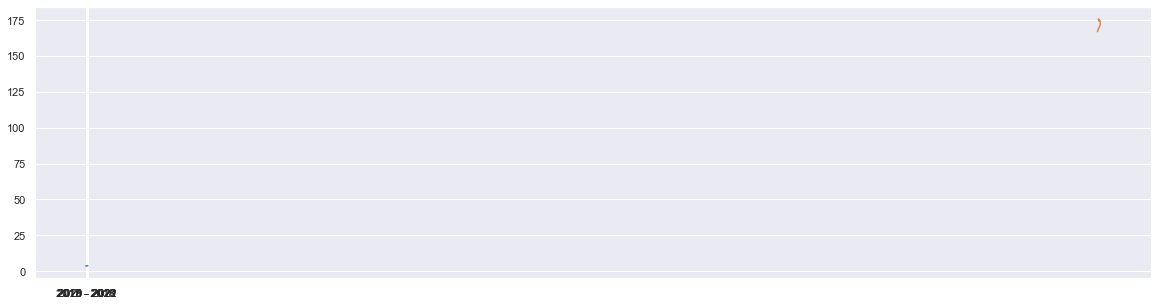

In [59]:
# По годам графики среднего балла по егэ и в барс
year_mark_EGE= df_merge_student_marks.loc[(df_merge_student_marks['Оценка. Код'] <= 5) & \
                           (df_merge_student_marks['Год обучения'] > '2016 - 2017')] \
    .groupby(['Год обучения' ])[['Оценка. Код', 'Студент. Сумма баллов ЕГЭ']]\
    .mean().reset_index()

#year_mark_EGE['combined']=year_mark_EGE['Год обучения']+'_'+year_mark_EGE['Семестр. Название']

plt.figure(figsize=(20, 5))
plt.plot(year_mark_EGE['Год обучения'], year_mark_EGE['Оценка. Код'])
plt.plot(df_student['Студент. Год поступления'].unique(),df_student.groupby(['Студент. Год поступления'])['Студент. Сумма баллов ЕГЭ'].mean())





## Варианты действий

* Посмотреть, как зависит балл за ЕГЭ и средний балл по БАРСу - можем ли мы по баллу ЕГЭ для поступающего предсказать его средний балл в институте? Отчислится ли он или нет?


In [60]:
#df_merge_student_marks.groupby('Студент. ИД').mean() 
df_merge_student_marks.loc[(df_merge_student_marks['Студент. Сумма баллов ЕГЭ'] > 150) & \
                           (df_merge_student_marks['Оценка. Код'] <= 5)] \
                            .groupby('Студент. ИД').mean()[['Студент. Сумма баллов ЕГЭ', 'Оценка. Код']].corr()


,Студент. Сумма баллов ЕГЭ,Оценка. Код
Студент. Сумма баллов ЕГЭ,1.000000,0.263247
Оценка. Код,0.263247,1.000000


In [61]:

pd.set_option('display.max_rows', 100)
df_merge_student_marks.loc[(df_merge_student_marks['Студент. Сумма баллов ЕГЭ'] > 150) & \
                           (df_merge_student_marks['Оценка. Код'] <= 5)] \
                            .groupby('Студент. ИД').mean()[['Студент. Сумма баллов ЕГЭ', 'Оценка. Код']].reset_index().head(100)

,Студент. ИД,Студент. Сумма баллов ЕГЭ,Оценка. Код
0,{00064C74-6179-E711-80C5-005056BEEEDD},184.0,2.767857
1,{000B500F-37B8-E911-80CF-005056BEEEDD},250.0,4.028571
2,{000C85D9-36B8-E911-80CF-005056BEEEDD},246.0,3.222222
3,{0010C6DC-1800-EC11-80D6-005056BEEEDD},268.0,4.000000
4,{001C1080-5FB9-E911-80CF-005056BEEEDD},199.0,3.823529
5,{001C41AF-4CB2-E911-80CF-005056BEEEDD},222.0,1.941176
6,{001D8CB3-A096-E811-80CB-005056BEEEDD},247.0,3.963636
7,{001E60FD-36B8-E911-80CF-005056BEEEDD},215.0,3.960000
8,{001F4E9E-7000-EC11-80D6-005056BEEEDD},175.0,4.500000
9,{00224582-5690-E811-80CB-005056BEEEDD},165.0,3.061224


### Вывод: 
Зависимости практически нет. Вероятно, надо почистить данные - как-то учитывать тех, у кого крайне низкий средний балл, что скорее всего говорит об отчислении

## Предложения
* Посмотреть типичных представителей студентов с низким баллом за ЕГЭ, но высоким баллом в институте и наоборот - Характерно ли это для какого-то конкретного факультета?

* Проанализаировать поступление студентов в магистратуру - какой средний балл? Как влияет КЦП на средний балл? Может ли мы предсказать количество желающих поступать?


## Готовим данные студенты-оценки к визуализации

In [62]:
df_merge_student_marks_envoded = df_student[["Личность. Пол", "Личность. Гражданство", "Студент. Сумма баллов ЕГЭ" ]]
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df_student_encoded["Личность. Гражданство"] = ord_enc.fit_transform(df_student[["Личность. Гражданство"]].fillna('unknown'))
df_student_encoded["Личность. Пол"] = ord_enc.fit_transform(df_student[["Личность. Пол"]].fillna('unknown'))
df_student_encoded.head(100)

,Личность. Пол,Личность. Гражданство,Студент. Сумма баллов ЕГЭ
0,1.0,62.0,70.0
1,1.0,62.0,64.0
2,1.0,15.0,100.0
3,1.0,62.0,80.0
4,1.0,62.0,66.0
5,1.0,62.0,65.0
6,1.0,62.0,65.0
7,1.0,62.0,62.0
8,1.0,62.0,64.0
9,1.0,62.0,64.0


MDS: 14 sec
t-SNE: 9.9 sec


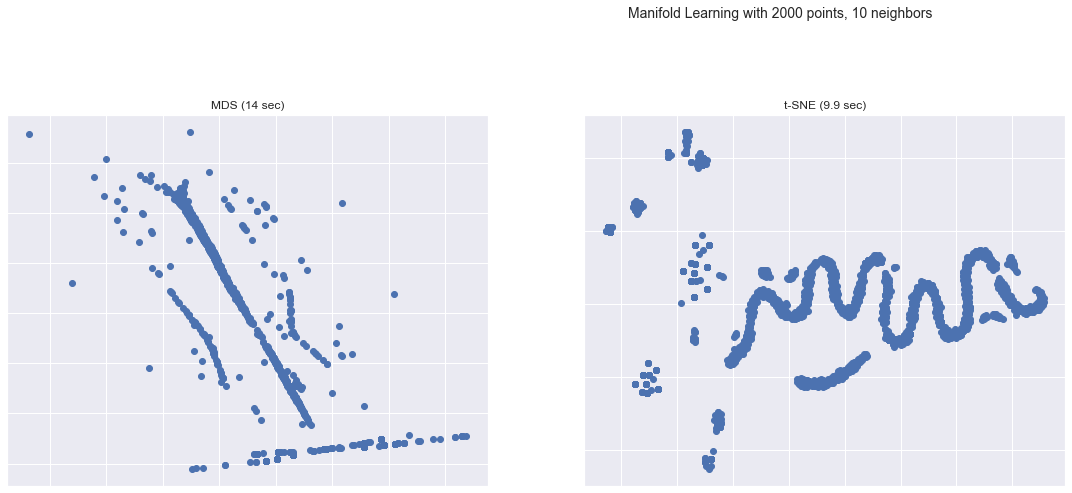

In [63]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 2000

n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(50, 15))
fig.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (n_points, n_neighbors), fontsize=14
)

# Add 3d scatter plot
#ax = fig.add_subplot(251, projection="3d")
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
#ax.view_init(4, -72)


LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver="auto",
)

methods = OrderedDict()
#methods["LLE"] = LLE(method="standard")
#methods["LTSA"] = LLE(method="ltsa")
#methods["Hessian LLE"] = LLE(method="hessian")
#methods["Modified LLE"] = LLE(method="modified")
#methods["Isomap"] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods["MDS"] = manifold.MDS(n_components, max_iter=100, n_init=1)
#methods["SE"] = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
methods["t-SNE"] = manifold.TSNE(n_components=n_components, init="pca", random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(df_student_encoded.fillna(0).head(n_points))
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

plt.show()